In [69]:
%reset -f

import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.compose import TransformedTargetRegressor
from keras.models import Sequential
from keras.layers import Dense, Dropout
from scikeras.wrappers import KerasRegressor
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
import Helpers
from xgboost import XGBRegressor

#import cleaned_data.csv to pandas.

data = pd.read_csv('cleaned_data.csv')

#data = data.drop(["HasCrCard", "NumOfProducts"], axis=1)

X_train, X_test, y_train, y_test = Helpers.split_data(data)

gradient_monitor = Helpers.GradientMonitor()


In [70]:
data

,CreditScore,Age,Balance,NumOfProducts,HasCrCard,EstimatedSalary,Geography,Gender
0,581,34.0,148882.54,1,1,84560.88,France,Male
1,588,36.0,131778.58,1,1,136024.31,Germany,Male
2,593,30.0,144772.69,1,1,29792.11,France,Female
3,678,37.0,138476.41,1,1,106851.60,Spain,Male
4,583,40.0,81274.33,1,1,170843.07,Germany,Male
...,...,...,...,...,...,...,...,...
125519,752,32.0,160729.10,1,1,142223.94,Spain,Male
125520,667,43.0,83765.35,1,1,118358.54,Germany,Female
125521,570,29.0,116099.82,1,1,148087.62,Spain,Male
125522,575,36.0,178032.53,1,1,42181.68,France,Female


In [83]:
# Define the features that need encoding and those that don't
categorical_features = ['Geography', 'Gender']
numerical_features = ['CreditScore', 'Age', 'Balance', 'NumOfProducts','HasCrCard']
#numerical_features = ['CreditScore', 'Age', 'Balance']


In [208]:
# Create transformers for the pipeline
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Adding RobustScaler for numerical features
#numerical_transformer = Pipeline(steps=[
#    ('poly', PolynomialFeatures(degree=2)),
#    ('scaler', RobustScaler())
#])

numerical_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())
])


In [209]:
# Combine transformers into a single ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ("num", numerical_transformer, numerical_features)
    ])




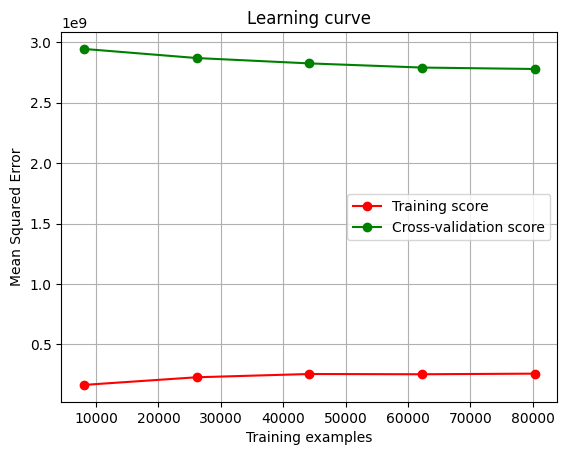

Cross-validated MSE on training set: 2776743810.816668


In [550]:

tt_regressor = TransformedTargetRegressor(regressor=XGBRegressor(reg_lambda=2, max_depth=80, verbosity=2, learning_rate=0.1, n_estimators=5000, min_child_weight=5, gamma=0.007),
                                          transformer=RobustScaler())

# Create the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', tt_regressor)
])

from sklearn.model_selection import learning_curve, cross_val_score
import numpy as np
import matplotlib.pyplot as plt

train_sizes, train_scores, test_scores = learning_curve(
    pipeline, X_train, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(.1, 1.0, 5),
    scoring='neg_mean_squared_error')

train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.title("Learning curve")
plt.xlabel("Training examples")
plt.ylabel("Mean Squared Error")
plt.legend(loc="best")
plt.grid()
plt.show()

scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(f'Cross-validated MSE on training set: {-np.mean(scores)}')


In [545]:



# Apply the pipeline to the data
pipeline.fit(X_train, y_train).score(X_test, y_test)


-0.09435106656406678

In [539]:
# Predict and evaluate
from sklearn.metrics import mean_squared_error
y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 3175667427.0142446


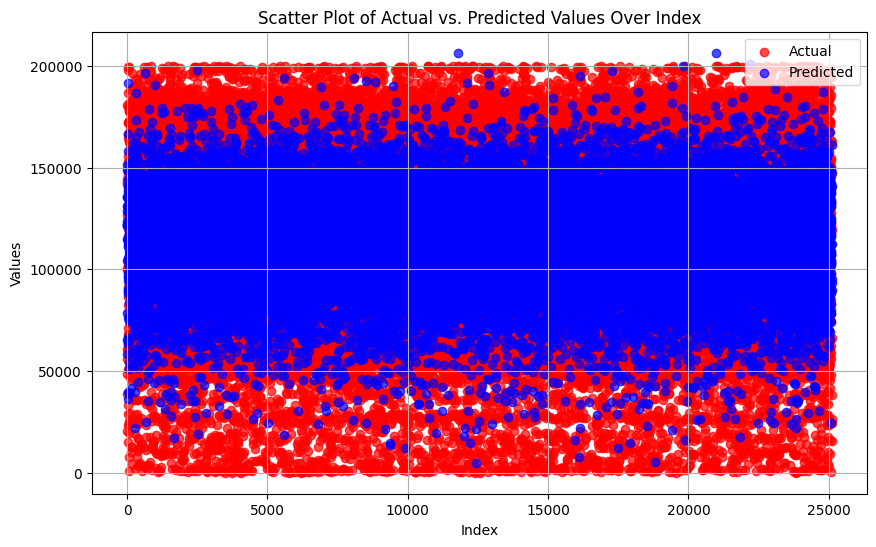

In [546]:
import matplotlib.pyplot as plt

# Predict using the pipeline
y_pred = pipeline.predict(X_test)

# Create indices for x-axis
index = range(len(y_test))

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(index, y_test, color='red', label='Actual', alpha=0.7)
plt.scatter(index, y_pred, color='blue', label='Predicted', alpha=0.7)

plt.title('Scatter Plot of Actual vs. Predicted Values Over Index')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()


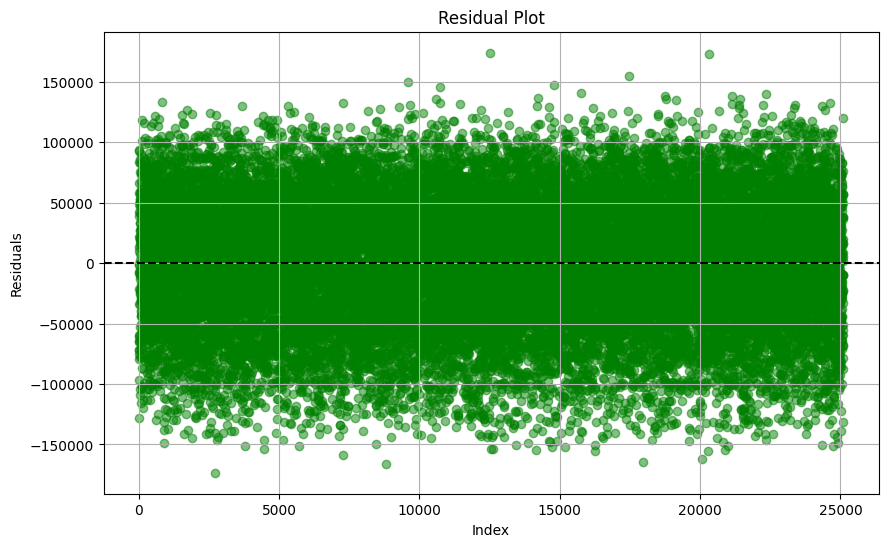

In [547]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), residuals, color='green', alpha=0.5)
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

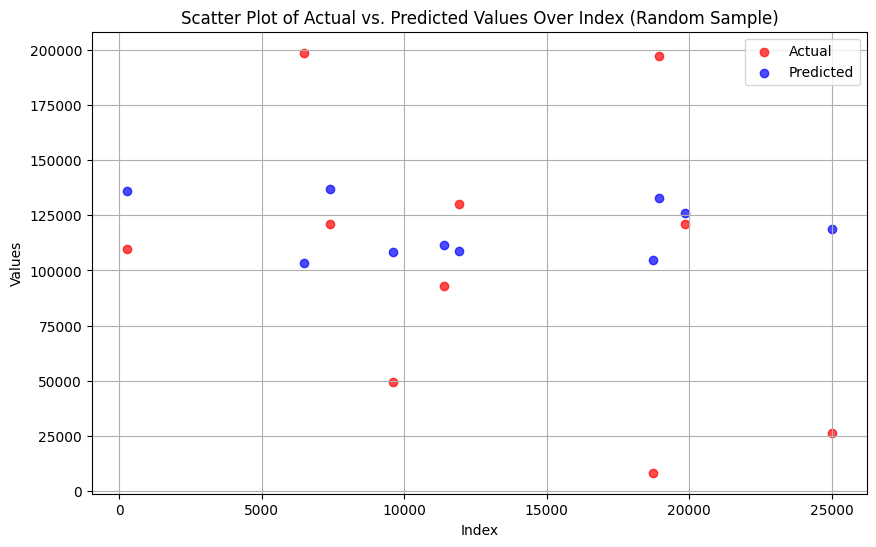

In [548]:
import numpy as np

# Predict using the pipeline
y_pred = pipeline.predict(X_test)

# Number of random samples to select
n_samples = 10

# Create random indices
random_indices = np.random.choice(range(len(y_test)), size=n_samples, replace=False)

# Create a subset of the actual and predicted values
y_test_sampled = y_test.iloc[random_indices]
y_pred_sampled = y_pred[random_indices]

# Create the scatter plot for the random sample
plt.figure(figsize=(10, 6))
plt.scatter(random_indices, y_test_sampled, color='red', label='Actual', alpha=0.7)
plt.scatter(random_indices, y_pred_sampled, color='blue', label='Predicted', alpha=0.7)

plt.title('Scatter Plot of Actual vs. Predicted Values Over Index (Random Sample)')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

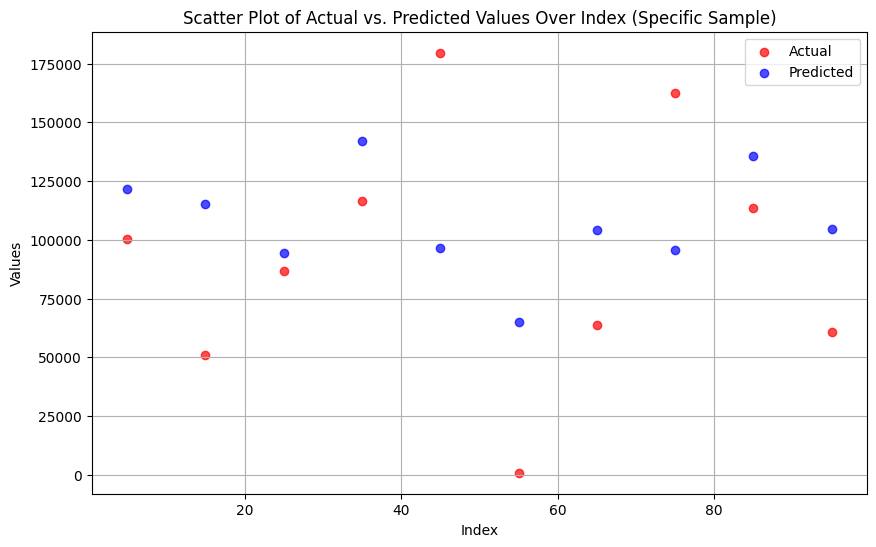

In [549]:
import numpy as np
import matplotlib.pyplot as plt

# Predict using the pipeline
y_pred = pipeline.predict(X_test)

# Define specific indices
specific_indices = [5, 15, 25, 35, 45, 55, 65, 75, 85, 95]

# Create a subset of the actual and predicted values
y_test_sampled = y_test.iloc[specific_indices]
y_pred_sampled = y_pred[specific_indices]

# Create the scatter plot for the specific sample
plt.figure(figsize=(10, 6))
plt.scatter(specific_indices, y_test_sampled, color='red', label='Actual', alpha=0.7)
plt.scatter(specific_indices, y_pred_sampled, color='blue', label='Predicted', alpha=0.7)

plt.title('Scatter Plot of Actual vs. Predicted Values Over Index (Specific Sample)')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()


In [529]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

param_grid = {
    'regressor__regressor__reg_lambda': [0.1, 1, 10, 40, 80, 120],  # Regularization lambda terms
    'regressor__regressor__learning_rate': [0.1, 0.2, 0.3, 0.5, 1, 1.5, 2],  # Learning rate values
    'regressor__regressor__min_child_weight': [0.1, 1, 10, 30, 50],  # Minimum sum of instance weight needed in a child
    'regressor__regressor__gamma': [0.001, 0.1, 0.25, 0.5, 1, 2],  # Minimum loss reduction required to make a further partition on a leaf node
    # Add other parameters if needed
}

# Initialize the GridSearchCV or RandomizedSearchCV object
# Note that 'pipeline' is the pipeline object you defined earlier
search_cv = RandomizedSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_iter=50, n_jobs=-1, verbose=1)

# Fit the model
search_cv.fit(X_train, y_train)

# Get the best parameters and the corresponding best score
best_params = search_cv.best_params_
best_score = search_cv.best_score_

print("Best parameters found: ", best_params)
print("Best score: ", best_score)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


KeyboardInterrupt: 

AttributeError: 'GridSearchCV' object has no attribute 'best_score_'